In [1]:
import os
import sys
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

x_test_reshape = [x_test[i].reshape((784)) for i in range(len(x_test))]
print(np.array(x_test_reshape).shape)

(60000, 784)
(10000, 784)


In [5]:
n_hidden_neurons = 256
lr = 0.001
epochs = 40 # clusterability paper uses 40 epochs. 20 training, 20 training with pruning
batch_size = 128
limit = (batch_size * (len(x_train) // batch_size)) # number of training examples to use. Must be multiple of batch_size
test_limit = (batch_size * (len(x_test) // batch_size)) # Must be multiple of batch_size
alpha = 1.0 # penalise polysemantic neurons.

In [6]:
sys.path.insert(0, '../clusterability_in_neural_networks/')
from src import spectral_cluster_model, train_nn

/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [7]:
i_save = tf.keras.layers.Input(shape=(28*28,))
e1_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i_save)
e2_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_2')(e1_save)
e3_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_3')(e2_save)
e4_save = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_4')(e3_save)
o_save = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e4_save)
model_save = tf.keras.Model(inputs=i_save, outputs=o_save)
# for i,layer in enumerate(model.layers[:5]):
#     print(layer)
#     model_save.layers[i].set_weights(layer.get_weights())
# model_save.save_weights('./mnist_penalise_polysemantic_neurons_all_classes_clusterability_weights.h5')
model_save.load_weights('./mnist_penalise_polysemantic_neurons_all_classes_clusterability_weights_loss_test.h5')
#model_save.load_weights('/Users/dwright/dev/P3/polysemantic-neurons/experiments/mnist/alpha_1.0/trial_1/inference_model.h5')

2022-06-08 06:43:27.226377: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-08 06:43:27.247578: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc81162ac50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-08 06:43:27.247593: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [8]:
weights = [w for w in model_save.get_weights() if len(w.shape)==2] # skip biases
print(weights[-1].shape)
adj_mat = spectral_cluster_model.weights_to_graph(weights)

(256, 10)


In [9]:
adj_mat

<1818x1818 sparse matrix of type '<class 'numpy.float64'>'
	with 799744 stored elements in Compressed Sparse Row format>

(-0.5, 1817.5, 1817.5, -0.5)

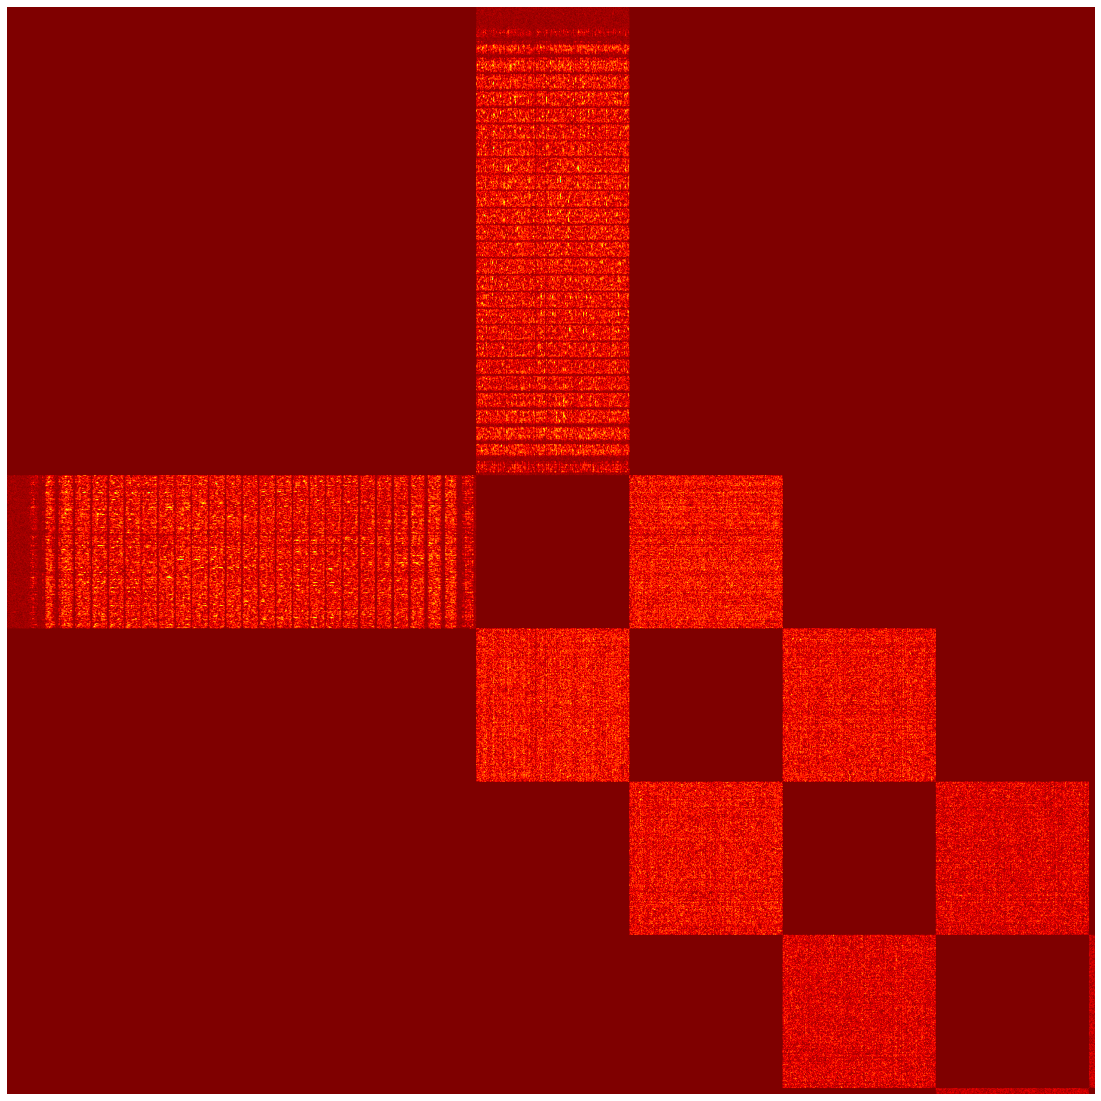

In [10]:
fig=plt.figure(figsize=(20,20))
plt.imshow(adj_mat.toarray(), cmap='jet_r')
plt.axis('off')

In [11]:
clustering_labels = spectral_cluster_model.cluster_net(12, adj_mat, 'arpack', assign_labels='kmeans')

In [12]:
clustering_labels

array([ 6,  6,  6, ..., 11, 11, 11], dtype=int32)

In [13]:
clustering_labels.shape

(1818,)

In [14]:
model_save.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
softmax (Dense)              (None, 10)                2570      
Total params: 400,906
Trainable params: 400,906
Non-trainable params: 0
_______________________________________________________

In [15]:
784+256+256+256+256+10

1818

In [16]:
256+256+256+256+10

1034

In [17]:
cca = spectral_cluster_model.connected_comp_analysis(weights, adj_mat)

In [18]:
cca

{'num_comps': 1,
 'counts_dict': {1818: 1},
 'prop_each_layer': array([0., 0., 0., 0., 0., 0.])}

In [65]:
def visualise_hidden_neurons(model, layer_index, n_hidden_neurons, vis_shape):
    W = model.layers[layer_index].get_weights()
    fig = plt.figure(figsize=(20,20))
    dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
    for j in range(n_hidden_neurons):
        x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
        #x_j[np.where(x_j <= -0.1)] = 0
        ax = fig.add_subplot(dim,dim,j+1)
        ax.imshow(x_j.reshape(vis_shape), cmap='hot')
        plt.axis('off')
    plt.show()

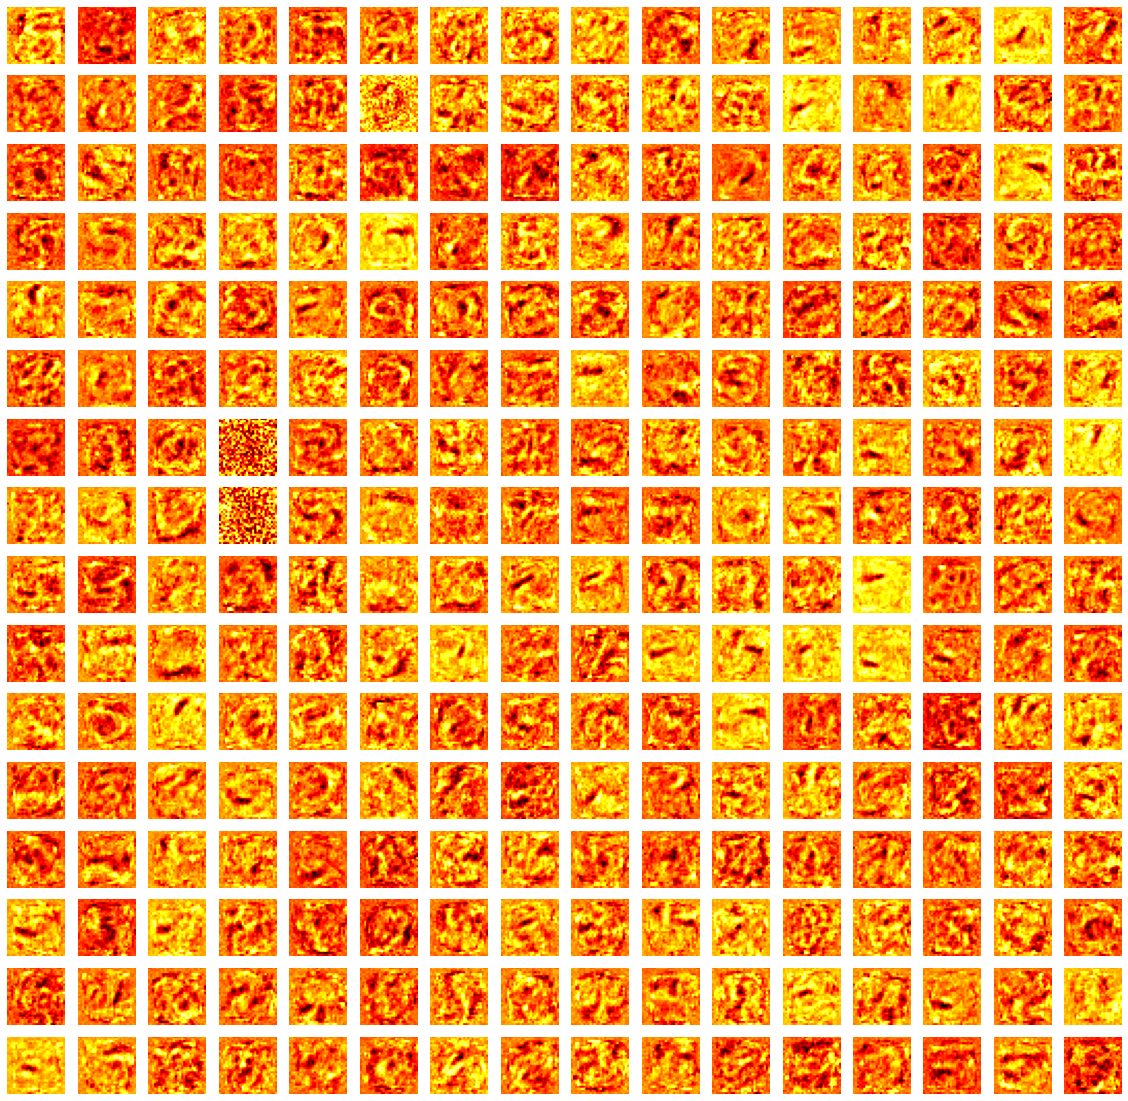

In [66]:
visualise_hidden_neurons(model_save, 1, n_hidden_neurons, (28, 28))

In [21]:
# for l in np.unique(clustering_labels):
#     mask = np.where(clustering_labels[:784]==l)
#     if len(mask[0])==0:
#         continue
#     print(l)
#     print(mask[0])

0


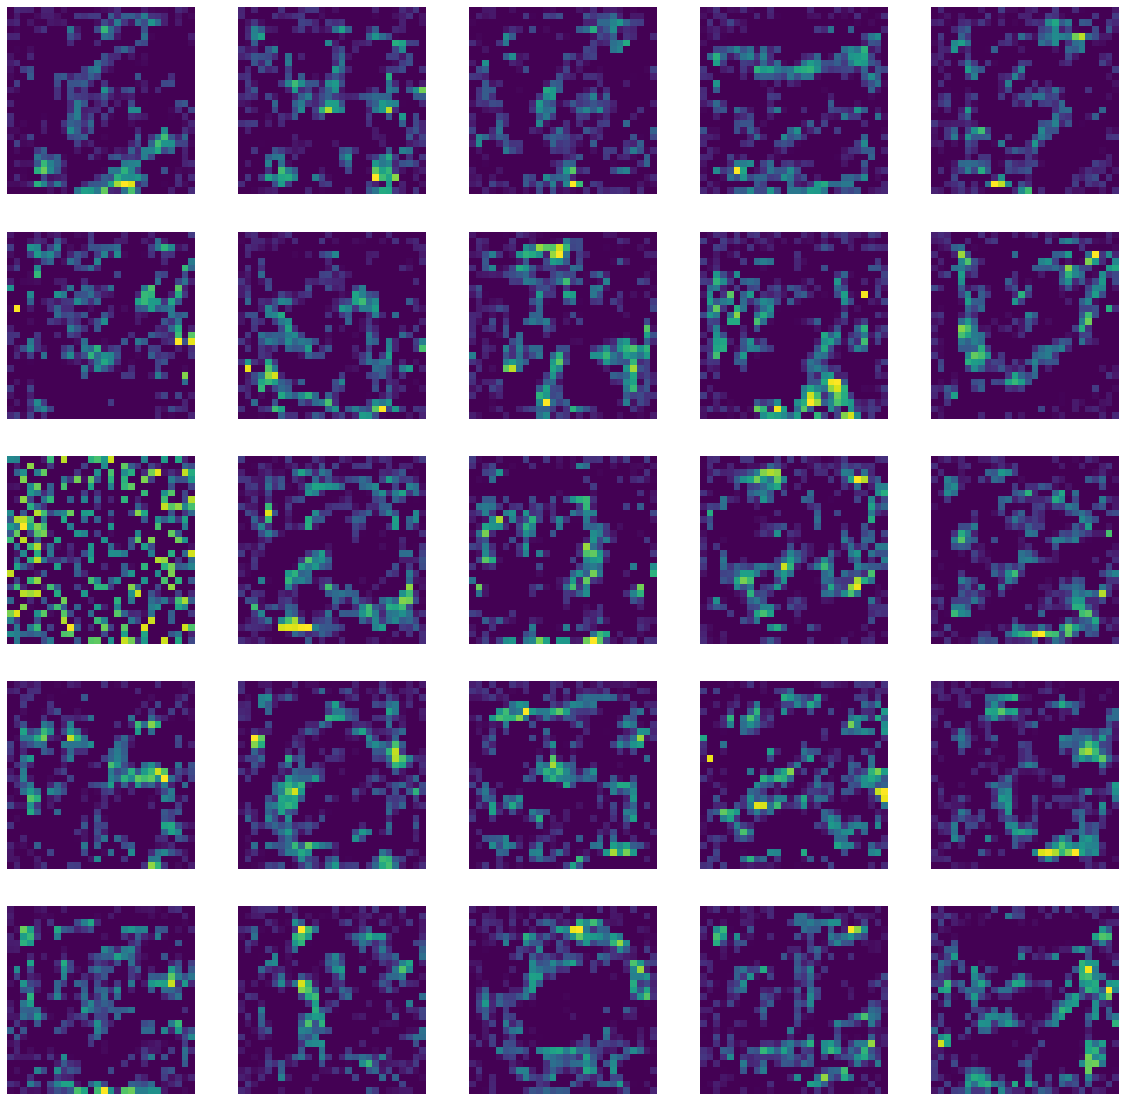

1


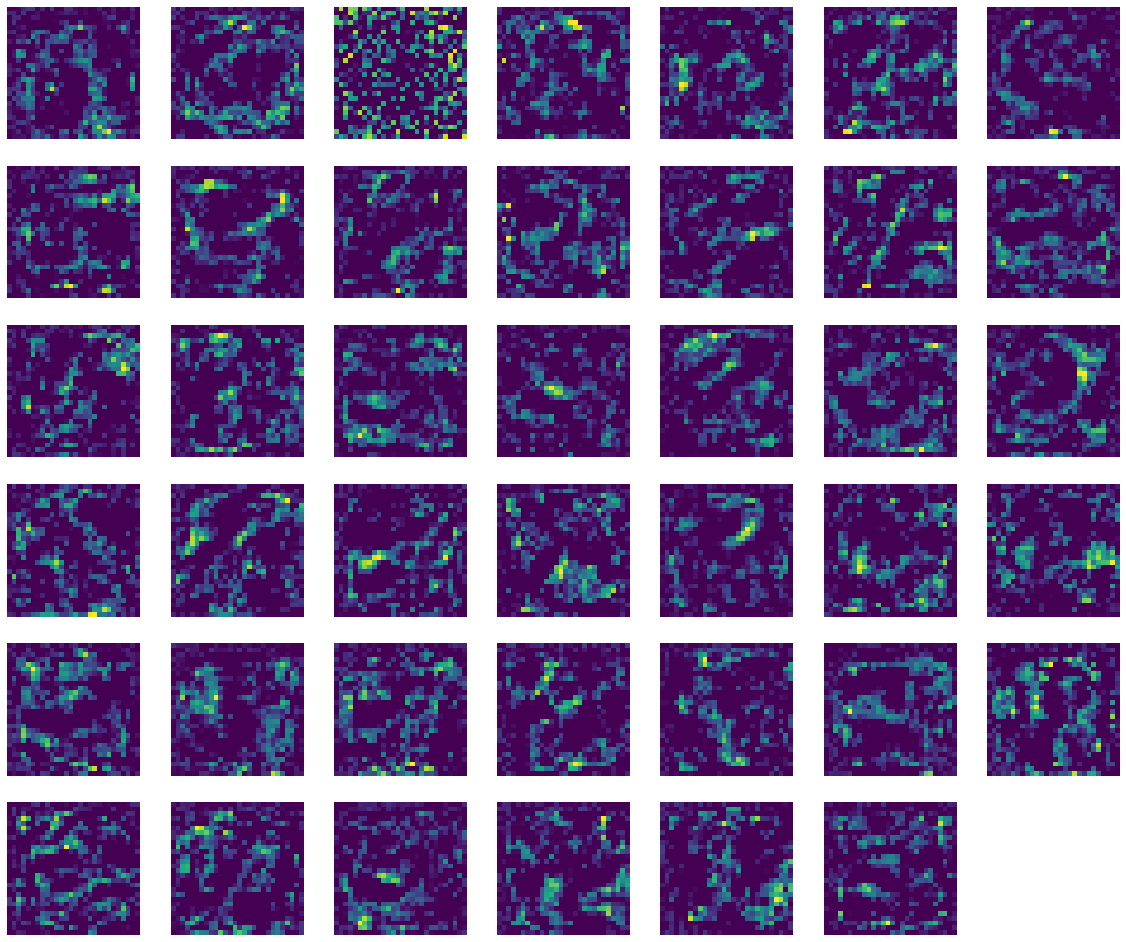

3


6


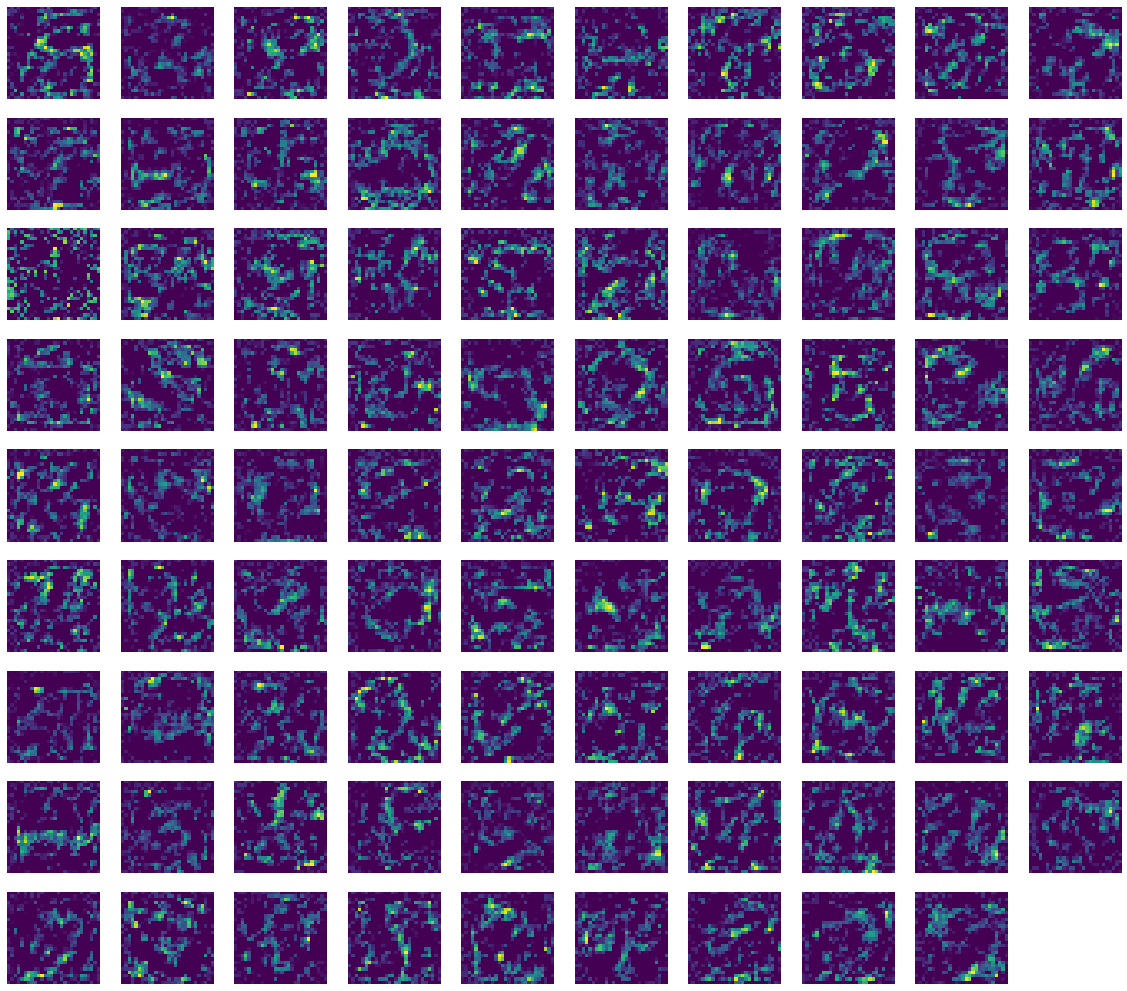

8


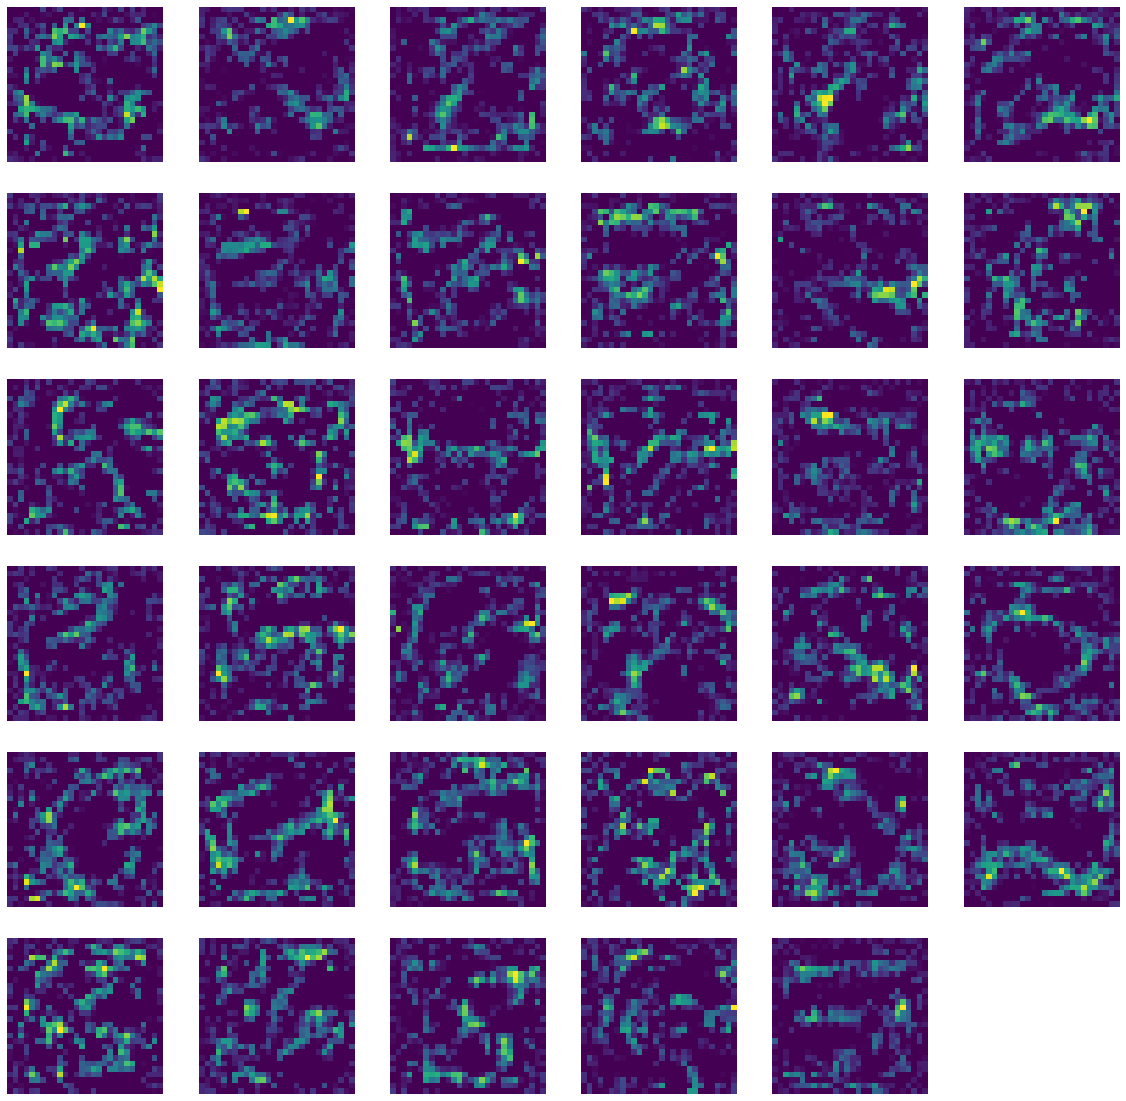

9


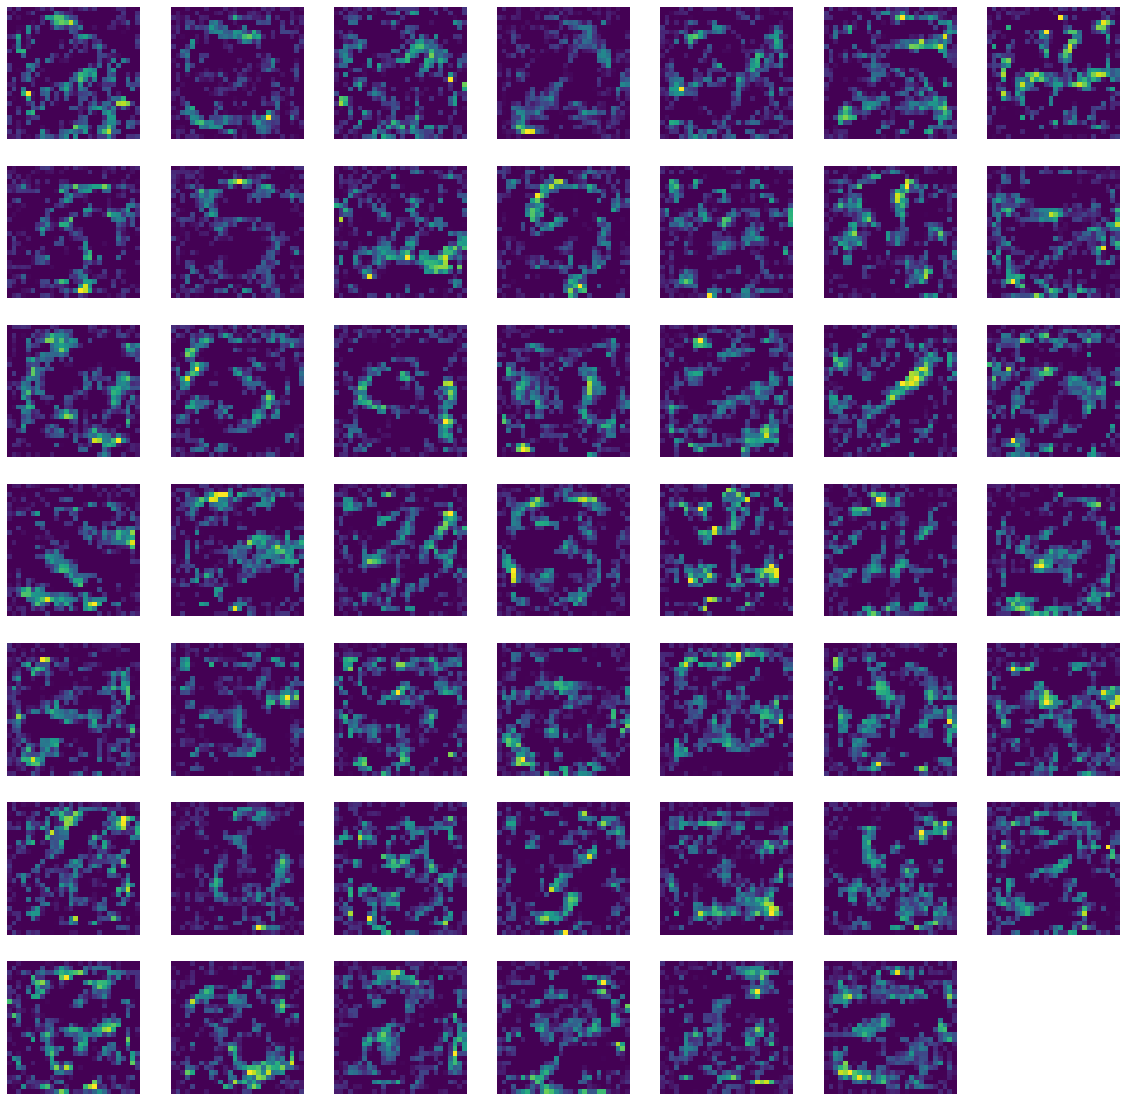

In [50]:
W = model_save.layers[1].get_weights()
for l in np.unique(clustering_labels):
    #mask = np.where(clustering_labels[784+0*256:784+1*256]==l)
    mask = np.where(clustering_labels[0*256:1*256]==l)
    if len(mask[0])==0:
        continue
    print(l)
    dim = int(np.ceil(np.sqrt(len(mask[0]))))
    fig = plt.figure(figsize=(20,20))
    for index, j in enumerate(mask[0]):
        #print(index, j
        x_j = W[0][:,j] #/ np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
        #x_j[np.where(x_j <= 0.0)] = 0
        ax = fig.add_subplot(dim,dim,index+1)
        ax.imshow(x_j.reshape(28,28))
        plt.axis('off')
    plt.show()

In [23]:
for l in np.unique(clustering_labels):
    #mask = np.where(clustering_labels[784+1*256:784+2*256]==l)
    mask = np.where(clustering_labels[1*256:2*256]==l)
    if len(mask[0])==0:
        continue
    print(l)
    print(mask[0])

0
[ 49  78 101 103 128 129 130 131 158 159 160 168 184 196 211 212 213 214
 238 239 240 241 248]
1
[ 6  8  9 10 37 79 84]
3
[ 11  12  13  14  15  16  17  18  19  20  40  41  42  43  44  45  46  47
  48  69  70  71  72  73  74  75  97  98  99 100 102]
5
[ 56 171 172 173 174 175 176 194 197 198 199 200 201 202 203 204 205 224
 225 226 227 228 229 230 231 232 233 253 254 255]
6
[  0   1   2   3   4   5  24  27  28  50  52  55  76  80  85  96 105 108
 112 124 125 126 127 136 139 150 151 152 153 154 155 156 157 164 177 179
 180 181 182 183 192 195 206 207 208 209 210 215 216 220 221 234 235 236
 237 242 243 244 245 249]
7
[  7  29  30  31  32  33  34  35  36  57  58  59  60  61  62  63  64  65
  86  87  88  89  90  91  92 113 114 115 116 117 118 119 140 141 142 143
 144 145 146 165 169 170]
8
[ 22  23  25  26  38  39  51  53  54  66  67  68  81  83  93  94  95 104
 106 109 110 111 120 121 122 123 132 133 137 138 147 148 149 161 166 167
 178 186 187 188 189 193 222 223 250 251 252]
9
[ 21  7

In [24]:
for l in np.unique(clustering_labels):
#     mask = np.where(clustering_labels[784+2*256:784+3*256]==l)
    mask = np.where(clustering_labels[2*256:784+2*256]==l)
    if len(mask[0])==0:
        continue
    print(l)
    print(mask[0])

0
[ 10  11  12  13  15  38  39  40  41  42  43  47  66  67  68  69  70  93
  94  95  96  97  98 121 122 123 124 126 135 149 150 151 163 178 274 279
 282 311 319 352 367 381 386 388 397 415 421 423 426 431 462 465 467 494
 498 502 514 519 523]
1
[301 307 312 329 336 337 383 389 430 434 446 454 459 503]
2
[544 554 592 593 614 634 710 757 765 775 783]
3
[287 300 318 321 325 328 348 366 395 417 442 452 457 470 489 513 521 526]
4
[529 531 532 534 535 536 537 538 539 540 543 545 547 548 550 552 553 555
 556 558 559 560 561 562 563 564 566 568 569 570 571 573 575 576 577 578
 579 580 582 583 584 586 587 588 589 590 594 596 597 599 600 601 602 605
 606 607 608 610 612 613 616 617 618 619 620 621 622 624 625 626 627 628
 629 630 631 632 635 636 637 638 639 640 641 642 643 644 645 647 648 649
 650 651 652 653 654 656 658 659 660 661 662 663 664 666 668 671 672 676
 678 679 680 681 682 684 686 687 688 690 695 698 700 701 702 703 704 705
 706 708 709 712 713 714 716 717 719 720 724 725 726 727 730

In [25]:
for l in np.unique(clustering_labels):
#     mask = np.where(clustering_labels[784+3*256:784+4*256]==l)
    mask = np.where(clustering_labels[3*256:4*256]==l)
    if len(mask[0])==0:
        continue
    print(l)
    print(mask[0])

0
[ 18  23  26  55  63  96 111 125 130 132 141 159 165 167 170 175 206 209
 211 238 242 246]
1
[ 45  51  56  73  80  81 127 133 174 178 190 198 203 247]
3
[ 31  44  62  65  69  72  92 110 139 161 186 196 201 214 233]
5
[ 27  33  39  43  70 124 129 143 144 146 172 173 182 183 195 199 200 202
 207 224 244 248 253 254]
6
[ 12  13  14  15  16  17  21  25  28  34  35  36  37  38  42  48  50  57
  58  59  60  61  64  68  71  74  78  83  85  88  89  90  94  98  99 100
 101 107 108 109 112 113 114 115 116 118 119 122 123 126 131 134 137 138
 145 148 157 160 163 168 177 179 180 181 184 187 191 193 205 208 210 212
 213 216 221 222 225 227 229 230 231 235 237 241 250]
7
[ 49  82  84  87  97 104 106 136 140 151 152 156 169 171 232 243 251]
8
[  0   1   2   3   4   5   6   7   8   9  10  11  19  20  29  30  40  41
  46  47  52  53  76  79  86  91  93 103 120 128 135 142 147 154 158 166
 176 185 194 197 217 219 220 226 228 234 236 239 249 252]
9
[ 22  24  32  54  66  67  75  77  95 102 105 117 121 1

In [26]:
W1 = model_save.layers[1].get_weights()
W2 = model_save.layers[2].get_weights()
W3 = model_save.layers[3].get_weights()
W4 = model_save.layers[4].get_weights()

In [27]:
im = np.zeros((28,28))
for j in range(len(W2[0][:,0])):
    x_j = W1[0][:,j] / np.sqrt(np.sum(np.dot(W1[0][:,j], W1[0][:,j].T)))
    #if W2[0][j,0] > 0.2:
    im += W2[0][j,0] * x_j.reshape(28,28)

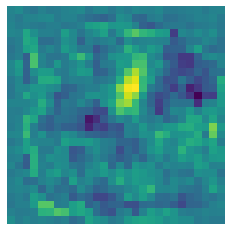

In [28]:
plt.imshow(im)
plt.axis('off')
plt.show()

In [29]:
im = np.zeros((28,28))
for j in range(len(W2[0][:,1])):
    x_j = W1[0][:,j] / np.sqrt(np.sum(np.dot(W1[0][:,j], W1[0][:,j].T)))
    if W2[0][j,1] > 0.2:
        im += W2[0][j,1] * x_j.reshape(28,28)

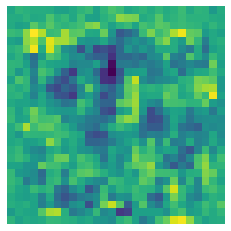

In [30]:
plt.imshow(im)
plt.axis('off')
plt.show()

In [31]:
W2[0].shape

(256, 256)

In [32]:
W2[0].shape

(256, 256)

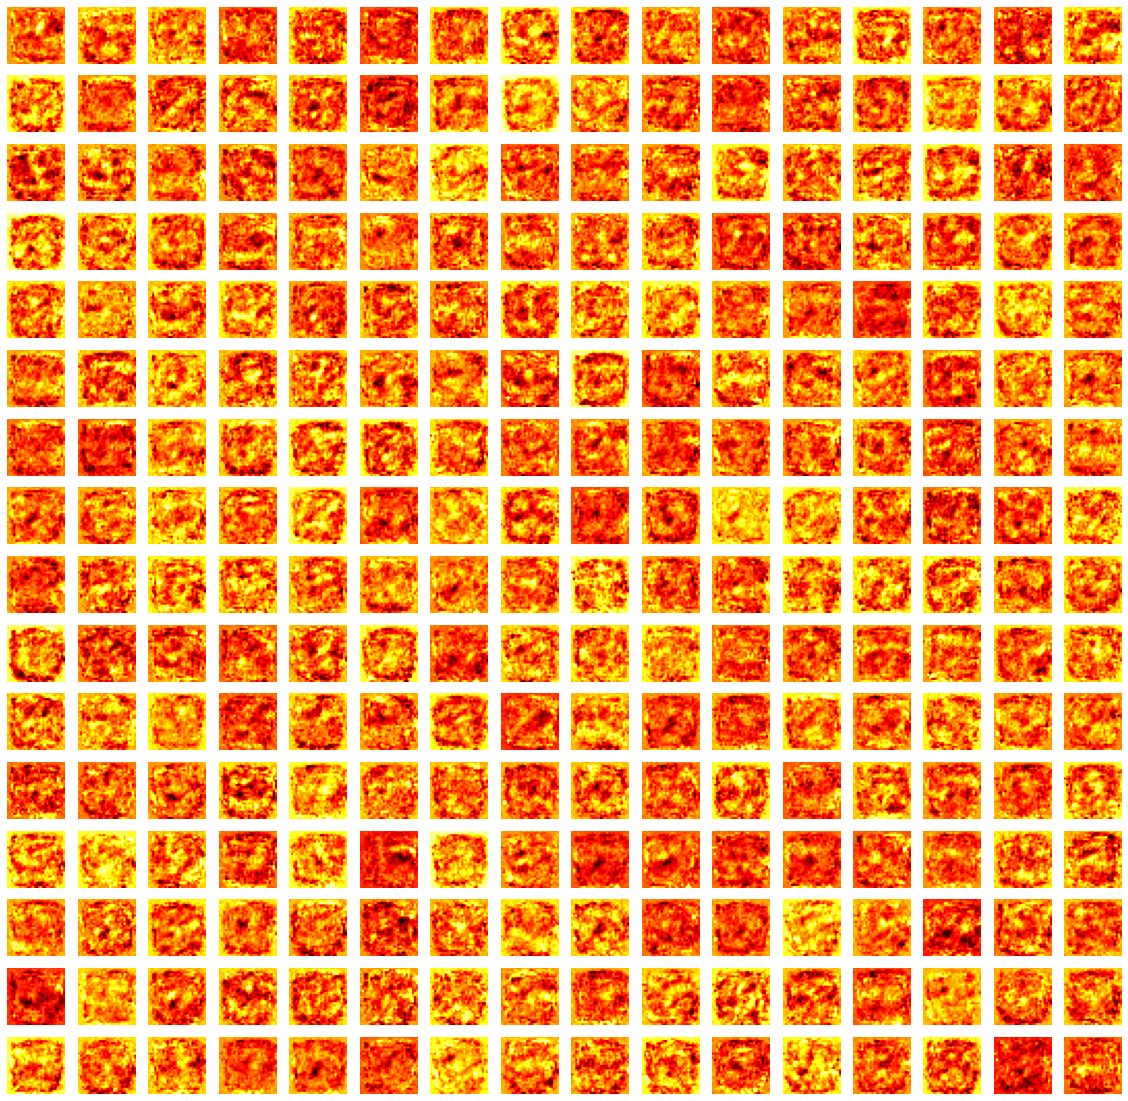

In [67]:
l2_images = []
fig = plt.figure(figsize=(20,20))
for j in range(256):
    im = np.zeros((28,28))
    ax = fig.add_subplot(16,16,j+1)
    #print(W2[0][:,j][W2[0][:,j]>0.1])
    ranking = np.argsort(W2[0][:,j])#[:3]
    for k in ranking:
        x_k = W1[0][:,k] #/ np.sqrt(np.sum(np.dot(W1[0][:,k], W1[0][:,k].T)))
        #x_k += np.min(x_k) + 1e-9
        #if W2[0][k,j] > 0.1:
        #    im += W2[0][k,j] * (x_k.reshape(28,28) / np.max(x_k))
        x_k[np.where(x_k <= 0.0)] = 0
        im += W2[0][k,j] * (x_k.reshape(28,28) / np.max(x_k))
    #print(im)
    l2_images.append(im)
    ax.imshow(im, cmap='hot')
    plt.axis('off')
plt.show()

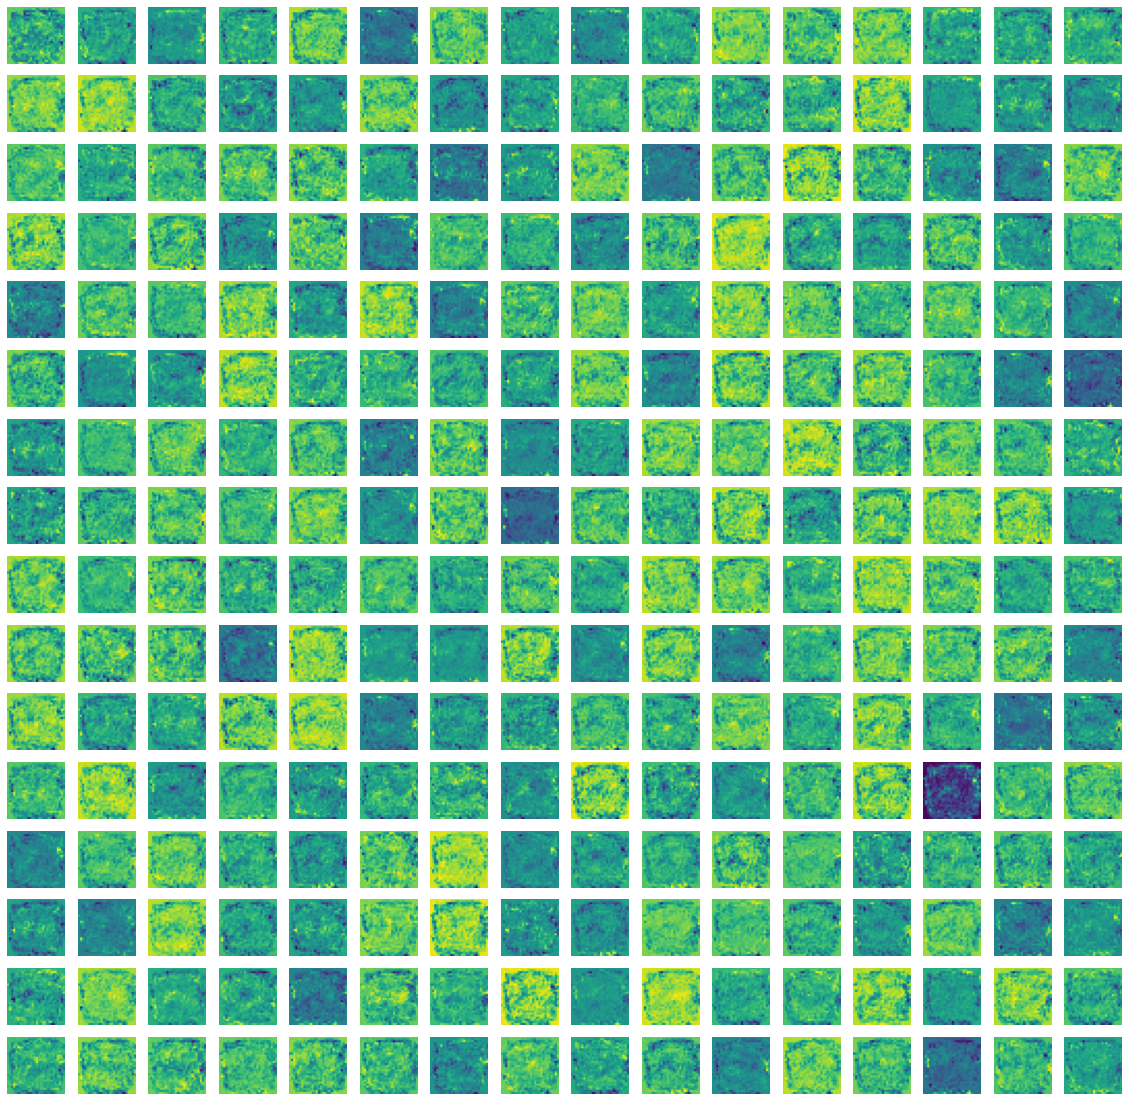

In [68]:
l3_images = []
fig = plt.figure(figsize=(20,20))
for j in range(256):
    im = np.zeros((28,28))
    ax = fig.add_subplot(16,16,j+1)
    #print(W3[0][:,j])
    ranking = np.argsort(W3[0][:,j])#[:5]
    for k in ranking:
        x_k = l2_images[k]
        x_k[np.where(x_k <= 0.0)] = 0
        #if W3[0][k,j] > 0.1:
        #print(x_k)
        #print(W3[0][k,j])
        im += W3[0][k,j] * x_k
    l3_images.append(im)
    ax.imshow(im)
    plt.axis('off')
plt.show()

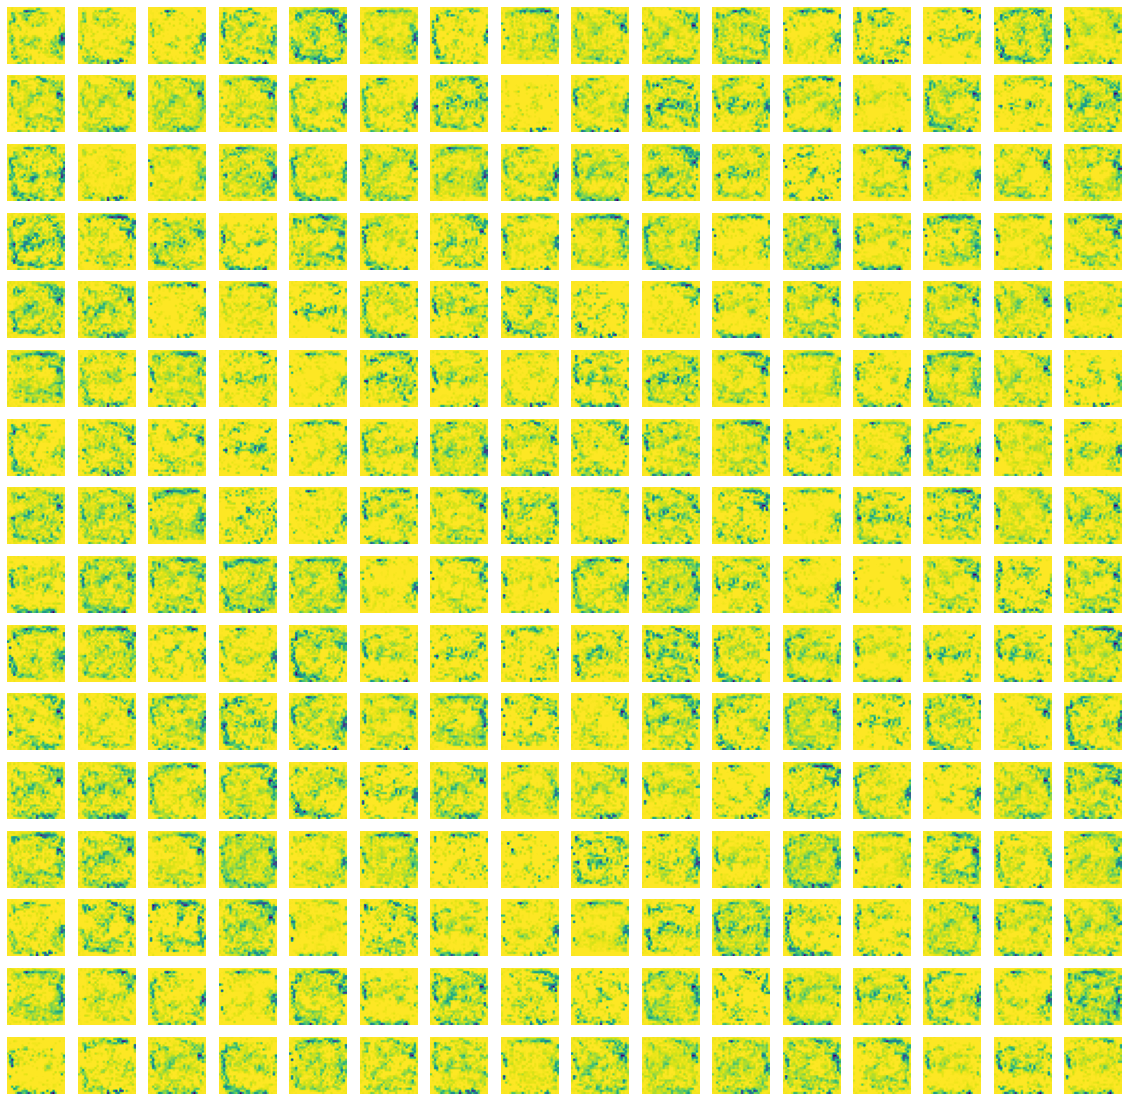

In [69]:
l4_images = []
fig = plt.figure(figsize=(20,20))
for j in range(256):
    im = np.zeros((28,28))
    ax = fig.add_subplot(16,16,j+1)
    #print(W4[0][:,j][W4[0][:,j]>0.4])
    ranking = np.argsort(W4[0][:,j])[:5]
    for k in ranking:
        x_k = l3_images[k]
        x_k[np.where(x_k <= 0.0)] = 0
        #if W4[0][k,j] > 0.4:
        im += W4[0][k,j] * x_k.reshape(28,28)
    l4_images.append(im)
    ax.imshow(im)
    plt.axis('off')
plt.show()